In [2]:
import captum
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
import copy

from matplotlib.patches import Rectangle
from os import path
from skimage import io
from torch import optim
from torch.nn import functional as F
from torch.nn import Linear, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.models import mnasnet0_5
from captum.attr import visualization

In [18]:
import sys
 
# setting path
sys.path.append('..')
 
from EnsembleXAI import Metrics

In [3]:
def show_image_bbox(image, bboxes: pd.DataFrame, ax=None):
    if ax is not None:
        ax.imshow(image)
    else:
        plt.imshow(image)
        ax = plt.gca()
    for idx, bbox in bboxes.iterrows():
        x = (bbox[0] - bbox[2] / 2) * 512
        y = (bbox[1] - bbox[3] / 2) * 512

        rect = Rectangle((x, y), bbox[2] * 512, bbox[3] * 512, fill=False, edgecolor='r')
        ax.add_patch(rect)
        
        
class CropWeedDataset(Dataset):
    
    def __init__(self, labels_csv, images_dir, transform=None):
        self.labels_frame = pd.read_csv(labels_csv, index_col=0)
        self.grouped_labels_frame = self.labels_frame.groupby('filename').sum("label")
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.grouped_labels_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = path.join(self.images_dir,
                                self.get_filename(idx))
        image = io.imread(img_name)
        label = int(self.grouped_labels_frame.iloc[idx, 0] > 0)
        
        sample = {'image': image, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample
    
    def get_bbox(self, idx):
        bbox = self.labels_frame.loc[self.labels_frame['filename'] == self.grouped_labels_frame.iloc[idx].name].iloc[:,2:6]
        return bbox
    
    def get_filename(self, idx):
        return self.grouped_labels_frame.iloc[idx].name
    
    def show_image(self, idx, ax=None):
        sample = self[idx]
        bbox = self.get_bbox(idx)

        if self.transform:
            numpy_image = sample['image'].numpy().transpose(1, 2, 0)
        else:
            numpy_image = sample['image']

        show_image_bbox(numpy_image, bbox, ax)


    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image) / 255,
                'label': torch.asarray(label)}

labels_frame = pd.read_csv(path.join('..', '..', 'input', 'inz-data-prep', 'easy_labels_and_data.csv'), index_col=0)

dataset = CropWeedDataset(labels_csv=path.join('..', '..', 'input', 'inz-data-prep', 'easy_labels_and_data.csv'),
                          images_dir=path.join('..', '..', 'input','crop-and-weed-detection-data-with-bounding-boxes','agri_data', 'data'),
                          transform=ToTensor())

## Load model

In [4]:
model = mnasnet0_5()
model.classifier[1] = Linear(1280, 2)
model.load_state_dict(torch.load(path.join('..', 'models', 'mnasnet0_5'), map_location=torch.device('cpu')))
model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
explanations_dir = path.join('..', '..', 'input', 'crop-and-weed-explanations')
explanations = torch.stack([torch.load(path.join(explanations_dir, 'autoweighted.pt'), map_location=torch.device('cpu')),
                            torch.load(path.join(explanations_dir, 'supervised.pt'), map_location=torch.device('cpu'))],
                           dim=1)

In [6]:
explanations.shape

torch.Size([64, 2, 3, 512, 512])

In [8]:
def plot_image_and_explanations(idx):
    fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(14, 3*1))
    columns_names = ['Original', 'Autoweighted', 'SupervisedXAI']
    original_image = dataset[idx]['image'].cpu().numpy().transpose([1,2,0])
    for col, col_name in zip(ax, columns_names):
        col.title.set_text(col_name)
    ax[0].xaxis.set_ticks_position("none")
    ax[0].yaxis.set_ticks_position("none")
    ax[0].set_yticklabels([])
    ax[0].set_xticklabels([])
    ax[0].imshow(original_image, vmin=0, vmax=255)
    for j, col in enumerate(ax[1:]):
        #ith image, jth explanation
        #expl = explanations[i,j]
        expl = explanations[idx][j]
        sign = "all"
        cmap=None
        if expl.amin() >= 0:
            sign = "positive"
        _ = visualization.visualize_image_attr(np.transpose(expl.squeeze().cpu().numpy(), (1,2,0)),
                                     original_image=original_image,
                                     sign=sign,
                                     plt_fig_axis=(fig, col),
                                     show_colorbar=True,
                                     outlier_perc=2,
                                     cmap=cmap,
                                     use_pyplot=False,
                                     method='blended_heat_map' 
                                     )

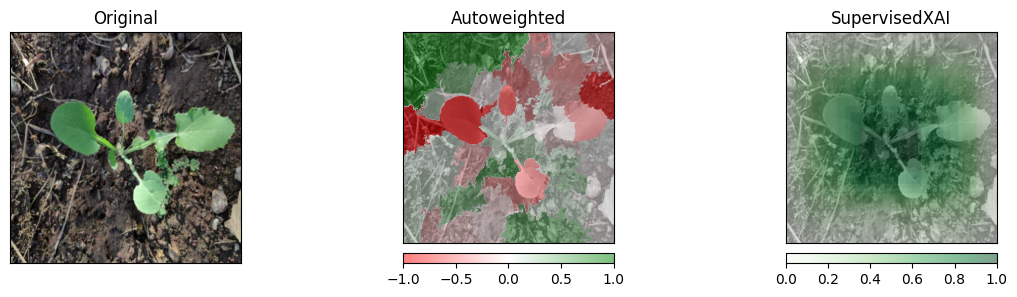

In [10]:
plot_image_and_explanations(45)

In [11]:
def to_numpy(tensor):
    return tensor.squeeze().cpu().numpy().transpose([1,2,0])

def bbox_to_mask(df, size=(512,512)):
    x_left = int(size[0] * (df.iloc[0]['x_cen'] - 0.5 * df.iloc[0]['w']))
    x_right = int(size[0] * (df.iloc[0]['x_cen'] + 0.5 * df.iloc[0]['w']))
    y_left = int(size[1] * (df.iloc[0]['y_cen'] - 0.5 * df.iloc[0]['h']))
    y_right = int(size[1] * (df.iloc[0]['y_cen'] + 0.5 * df.iloc[0]['h']))
    
    mask = torch.zeros(size)
    mask[y_left:y_right, x_left:x_right] = 1
    return mask

def normalize_0_1(x):
    return (x - x.min()) / (x.max() - x.min())

In [12]:
explanations_dict ={
    'Autoweighted': normalize_0_1(torch.load(path.join(explanations_dir, 'autoweighted.pt'), map_location=torch.device('cpu'))),
    'SupervisedXAI': normalize_0_1(torch.load(path.join(explanations_dir, 'supervised.pt'), map_location=torch.device('cpu'))),
}

In [16]:
predict = lambda x: torch.nn.Softmax(dim=1)(model(x))
bboxes = torch.load(path.join(explanations_dir, 'bboxes.list'))
masks = []
for i in range(64):
    masks += [bbox_to_mask(bboxes[i])]
    
masks = torch.stack(masks)

In [14]:
def dict_to_matrix(dataset, explanations_dict, predictor, masks_tensor):
    for i in range(16):
        df = pd.DataFrame()
        data = torch.stack([dataset[4 * i + j]['image'] for j in range(4)])
        masks = masks_tensor[4 * i : 4 * (i + 1)] 
        for key, value in explanations_dict.items():
            value = value[4*i:4*(i+1)]
            for thresh in range(0, 10):
                thresh_val = thresh/10
                df.loc[key, f"DIR{thresh_val}"] = Metrics.decision_impact_ratio(data, predictor, value, thresh_val, 0)
                df.loc[key, f"CIR Same{thresh_val}"] = Metrics.confidence_impact_ratio(data, predictor, value, thresh_val, 0, compare_to="same_prediction")
                df.loc[key, f"CIR Max{thresh_val}"] = Metrics.confidence_impact_ratio(data, predictor, value, thresh_val, 0, compare_to="new_prediction")
                df.loc[key, f"Average Recall{thresh_val}"] = torch.mean(Metrics.accordance_recall(value, masks, thresh_val)).item()
                df.loc[key, f"Average Precision{thresh_val}"] = torch.mean(Metrics.accordance_precision(value, masks, thresh_val)).item()
                df.loc[key, f"F1_score{thresh_val}"] = Metrics.F1_score(value, masks, thresh_val)
                df.loc[key, f"IOU{thresh_val}"] = Metrics.intersection_over_union(value, masks, thresh_val)
            del value
        df.to_csv('../../input/sesame_metrics/agg_explanations_{i}.csv'.format(i=i))
        del masks
        del df

In [19]:
dict_to_matrix(dataset, explanations_dict, predict, masks)

In [20]:
df = pd.DataFrame()
for i in range(16):
    df = pd.concat([df,pd.read_csv('../../input/sesame_metrics/agg_explanations_{i}.csv'.format(i=i), index_col=0)], axis=0)

In [23]:
mean_df = df.groupby(by=df.index).mean()

In [24]:
mean_df.loc[:, ['DIR' in i for i in mean_df.columns]]

,DIR0.0,DIR0.1,DIR0.2,DIR0.3,DIR0.4,DIR0.5,DIR0.6,DIR0.7,DIR0.8,DIR0.9
Autoweighted,0.46875,0.46875,0.46875,0.468750,0.062500,0.00000,0.000000,0.00000,0.00000,0.000000
SupervisedXAI,0.46875,0.46875,0.46875,0.421875,0.390625,0.21875,0.109375,0.03125,0.03125,0.015625
